<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/climatologia/src/vizcaina/Climatologia_Humedad_Vizcaina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_CLIMATOLOGIA = '/climatologia/figures/'
NOMBRE_ESTACION = 'vizcaina'

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
PATH_FINAL_FIGURAS_CLIMATOLOGIA = PATH_DRIVE + PATH_CLIMATOLOGIA + NOMBRE_ESTACION + '/humedad/'

FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_hum.csv'



In [12]:
VARIABLE = 'HUM'
VARIABLE_STR = 'Humedad'
NOMBRE_EJE_Y = 'Humedad Relativa (%)'

In [13]:
#Read the data

df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + FILE_DATOS_TRATADOS,
                 sep = ';', 
                #  parse_dates = ["FECHA"],
                #  date_parser = lambda col: pd.to_datetime(col)
                )

In [14]:
df['MES'] = df['FECHA'].apply(lambda x: x[5:7])
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

In [15]:
#Start every matrix

##Iniciate the month in every season
xnr = ['12', '01', '02', '06', '07', '08']
xr = ['03', '04', '05', '09', '10', '11']

##y is to make the hourly calculation
y = np.arange(0,24)

##Merge the dataframe, so that it will be only one for every season
nrain = df[df['MES'].str.contains('|'.join(xnr))] # DF con los datos de meses sin lluvia
rain = df[df['MES'].str.contains('|'.join(xr))]   # DF con los datos de meses con lluvia

## Use all the dataframe (No split)
total = df.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
total['mean'] = total[(VARIABLE, 'mean')]
total['std'] = total[(VARIABLE, 'std')]
total = total[['HORA', 'mean', 'std']]

#Fill the matrix of the no raining season
nrdf = nrain.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
nrdf['mean'] = nrdf[(VARIABLE, 'mean')]
nrdf['std'] = nrdf[(VARIABLE, 'std')]
nrain = nrdf[['HORA', 'mean', 'std']]


#Do the same for the the raining season
rdf = rain.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
rdf['mean'] = rdf[(VARIABLE, 'mean')]
rdf['std'] = rdf[(VARIABLE, 'std')]
rain = rdf[['HORA', 'mean', 'std']]
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


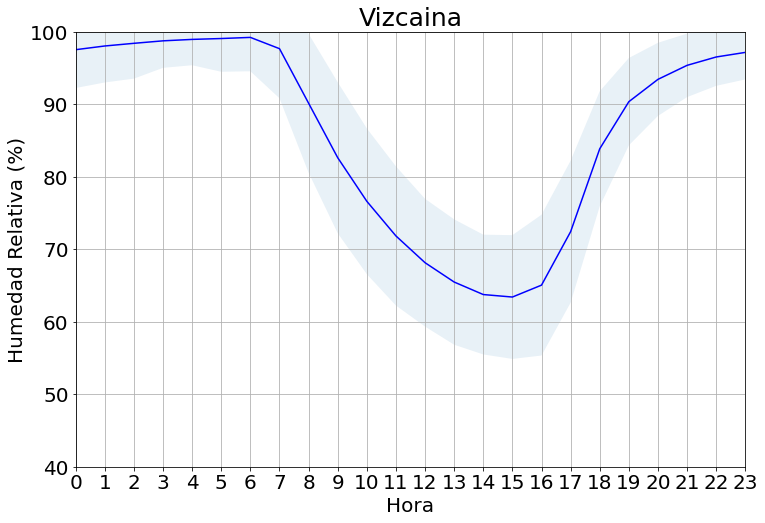

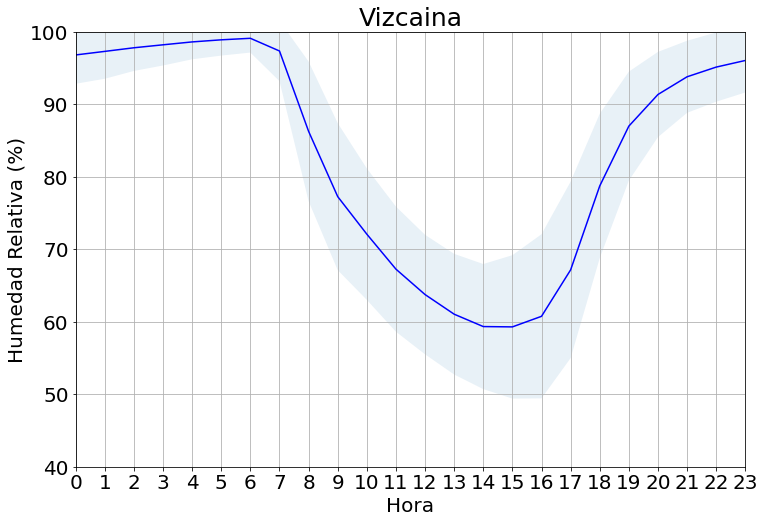

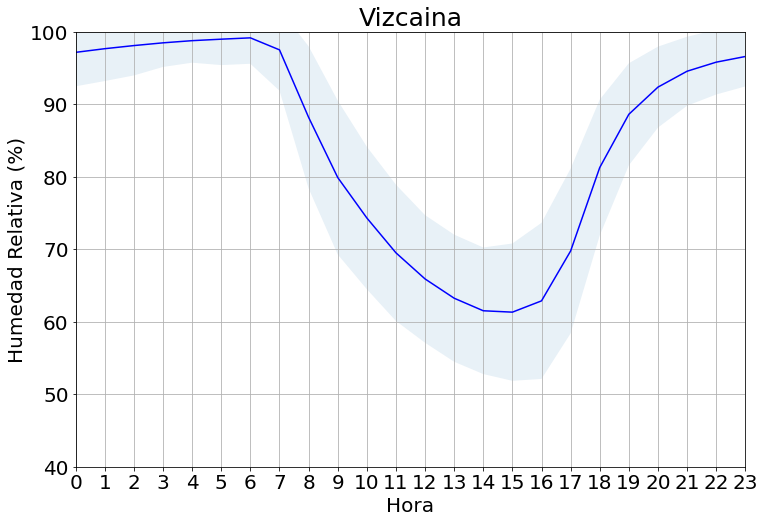

In [16]:
#I made a plot in a very automatic way, you need to improve it, I think a plot matrix es better, but you need to check
def plot_per_hour(df, titulo, name_to_save):
  plt.figure(figsize = (12,8))

  df['HORA'] = df['HORA'].astype(int)

  plt.xticks(df['HORA'], fontsize= 20)
  plt.plot(df['mean'], color = 'b')
  plt.fill_between(df['HORA'], df['mean'] + df['std'], df['mean'] - df['std'], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.grid()
  plt.xlim([0, 23])
  plt.ylim([40,100])
  plt.xlabel("Hora", fontsize= 20)
  plt.ylabel(NOMBRE_EJE_Y, fontsize= 20)
  plt.title(titulo, fontsize= 25)
  plt.yticks(fontsize= 20)
  plt.savefig(PATH_FINAL_FIGURAS_CLIMATOLOGIA + f'{name_to_save}', format='png', bbox_inches = 'tight' )


plot_per_hour(rain, f'{NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_lluvia.png')
plot_per_hour(nrain, f'{NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_no_lluvia.png')

plot_per_hour(total, f'{NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_todos_meses.png')

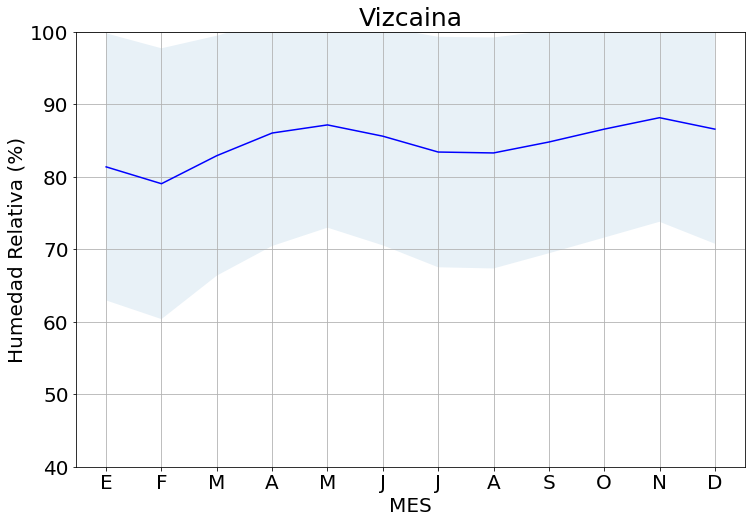

In [17]:
#Start every matrix

#Fill the matrix of the no raining season
dfmes = df.groupby('MES', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
dfmes['mean'] = dfmes[(VARIABLE, 'mean')]
dfmes['std'] = dfmes[(VARIABLE, 'std')]
dfmes = dfmes[['MES', 'mean', 'std']]

def plot_per_month(df, titulo, name_to_save):
  
  plt.figure(figsize = (12,8))
  df['MES'] = df['MES'].astype(int)

  # plt.xticks()
  plt.plot(df['MES'], df['mean'], color = 'b')
  plt.fill_between(df['MES'], df['mean'] + df['std'], df['mean'] - df['std'], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.grid()
  plt.xlabel("MES", fontsize= 20)
  plt.ylabel(NOMBRE_EJE_Y, fontsize= 20)
  plt.title(titulo, fontsize= 25)
  plt.yticks(fontsize= 20)
  plt.ylim([40,100])
  Meses = ['E', 'F', 
         'M', 'A', 
         'M', 'J', 
         'J', 'A', 
         'S', 'O', 
         'N', 'D']

  plt.xticks(range(1, 13, 1), labels = Meses, fontsize= 20)
  
  plt.savefig(PATH_FINAL_FIGURAS_CLIMATOLOGIA + f'{name_to_save}', format='png', bbox_inches = 'tight' )

plot_per_month(dfmes, f'{NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_por_meses.png')

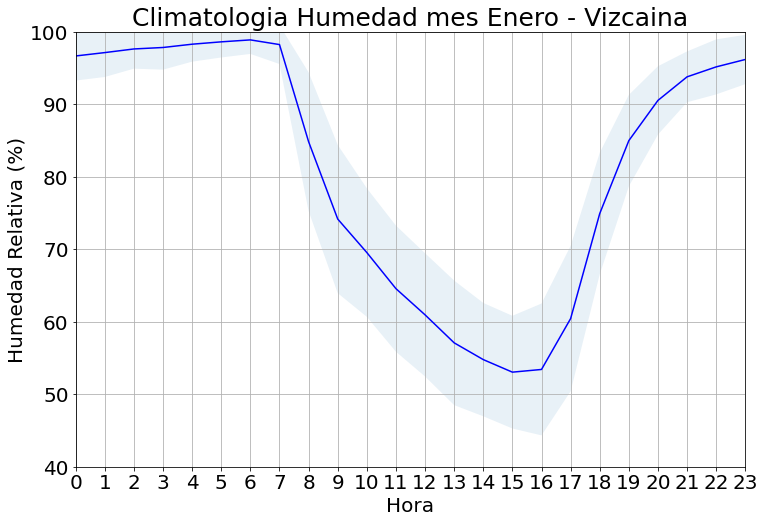

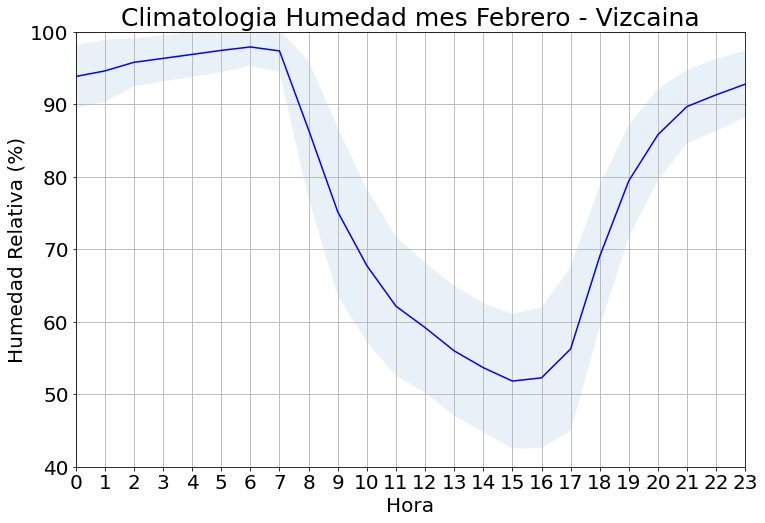

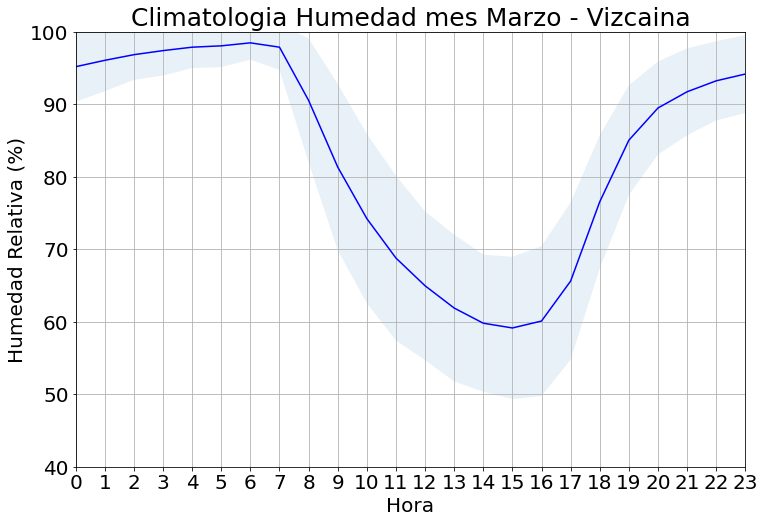

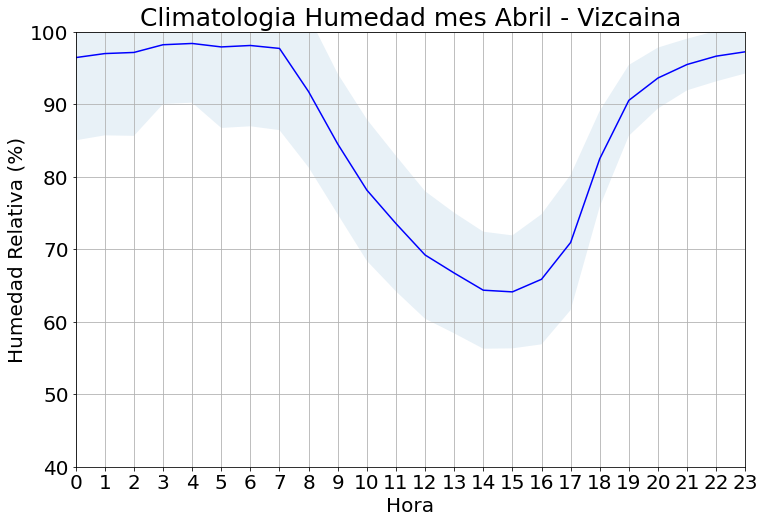

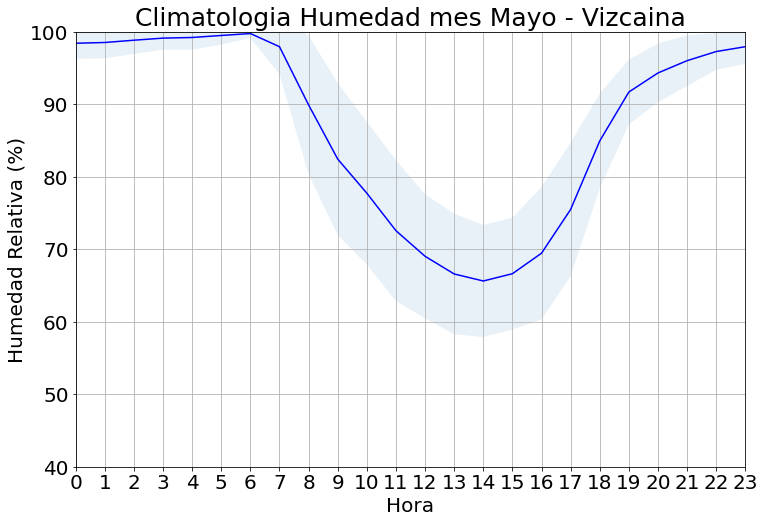

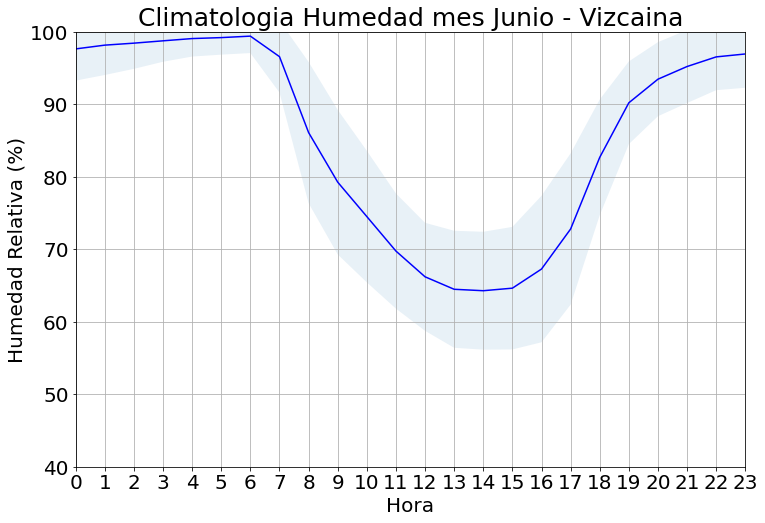

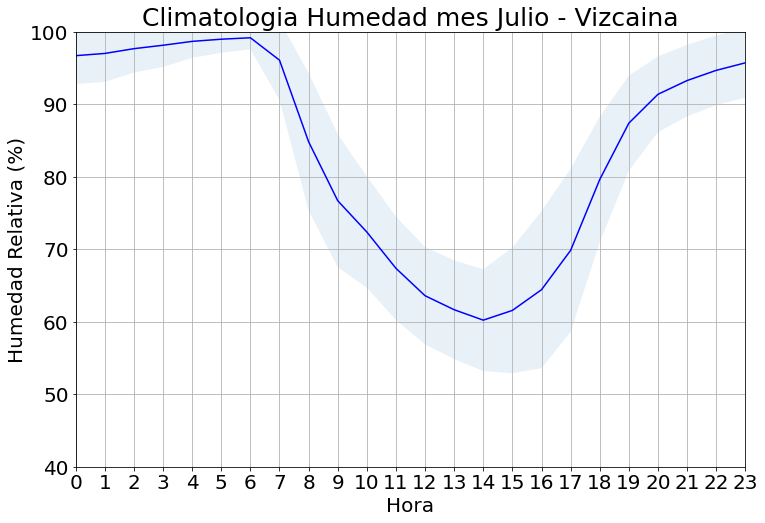

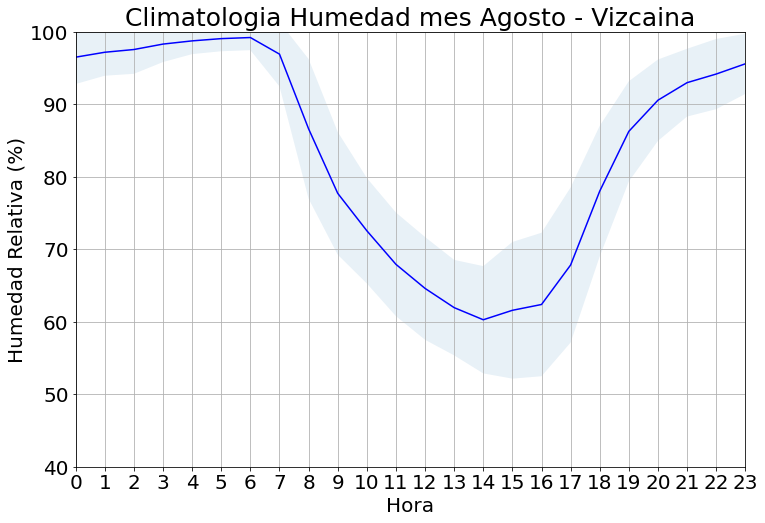

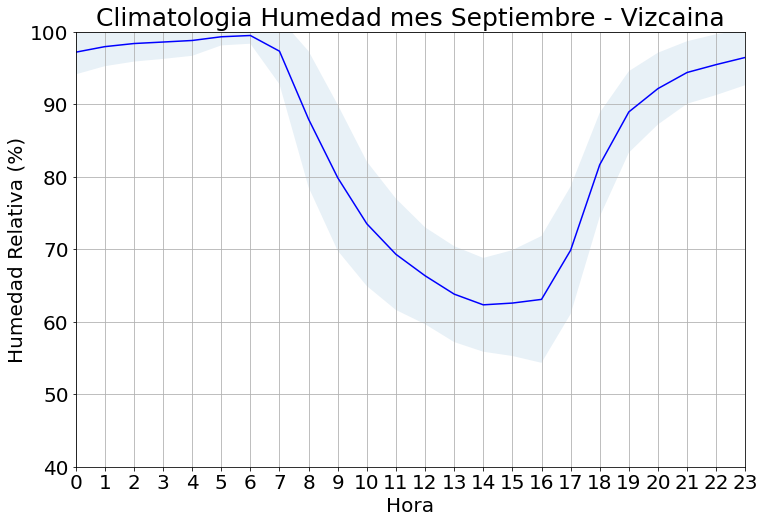

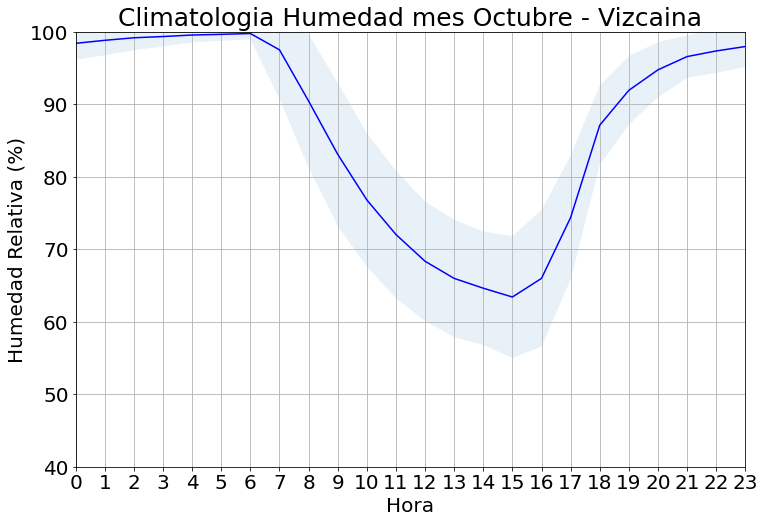

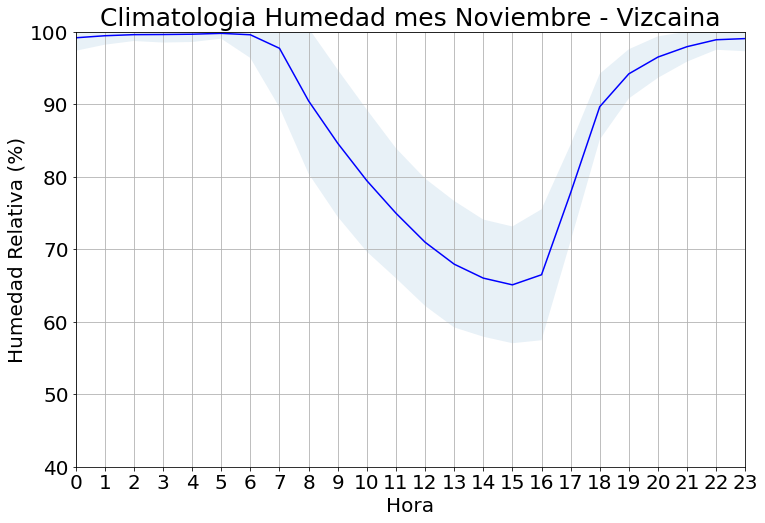

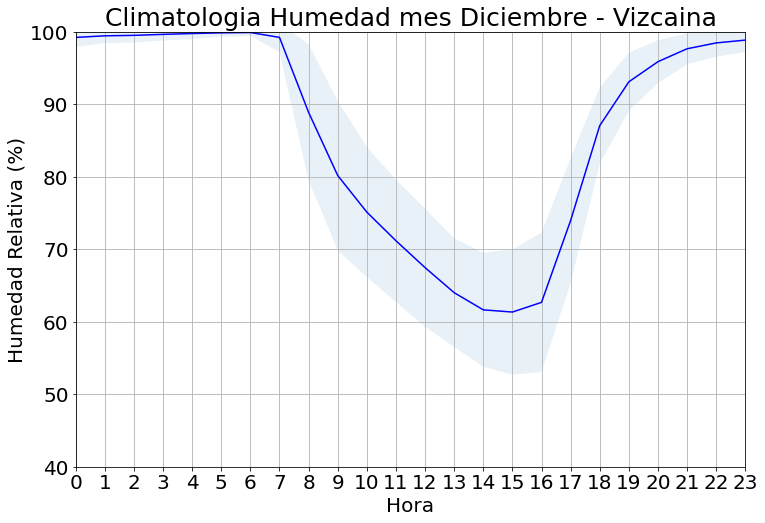

In [18]:
meses = [str(i).zfill(2) for i in range(1, 13)]
meses_str = ['Enero', 'Febrero', 
         'Marzo', 'Abril', 
         'Mayo', 'Junio', 
         'Julio', 'Agosto', 
         'Septiembre', 'Octubre', 
         'Noviembre', 'Diciembre']


for mes, mes_str in zip(meses, meses_str):
  #Merge the dataframe, so that it will be only one for every season
  dfmes = df[df['MES'].str.contains(mes)]   # DF con los datos de meses con lluvia
  total = dfmes.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
  total['mean'] = total[(VARIABLE, 'mean')]
  total['std'] = total[(VARIABLE, 'std')]
  total = total[['HORA', 'mean', 'std']]

  plot_per_hour(total, f'Climatologia {VARIABLE_STR.capitalize()} mes {mes_str} - {NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_mes_{mes}.png')